## Installation of packages

First of all we need to find out what version of cuda we have on the server. 

In [ ]:
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


Then we install the pytorch version for the corresponding cuda version and the other packages.

In [ ]:
!pip install torch==1.7.1+cu101 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html
!pip install pytorch-lightning
!pip install mirdata torchaudio scikit-learn

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 735.4MB 25kB/s 
     |████████████████████████████████| 7.6MB 8.0MB/s 
ERROR: torchvision 0.8.1+cu101 has requirement torch==1.7.0, but you'll have torch 1.7.1+cu101 which is incompatible.
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
     |████████████████████████████████| 696kB 8.6MB/s 
     |████████████████████████████████| 829kB 16.1MB/s 
     |████████████████████████████████| 102kB 8.1MB/s 
     |████████████████████████████████| 276kB 21.8MB/s 
     |████████████████████████████████| 1.3MB 38.7MB/s 
     |████████████████████████████████| 296kB 38.8MB/s 
     |████████████████████████████████| 143kB 39.6MB/s 
  Created wheel for future: filename=future-0.18.2-cp36-none-any.whl size=491057 sha256=d41a975a8713e345ed999398114941746b7a8fd12d029aa3edb124d78704c90e
  Stored in directory: /r

We import the packages and we set the random_seed for our experiments. The random seed makes sure the experiment is reproducible on this environment.

We use mirdata to load the datasets, sklearn for data partitioning, torchaudio to load and transform audio files, and pytorch lightning on top of pytorch for machine learning. 

In [ ]:
import mirdata
import numpy as np
import sklearn
import random
import torch
import torchaudio
import pytorch_lightning as pl
random_seed=0
pl.utilities.seed.seed_everything(seed=random_seed)

/usr/local/lib/python3.6/dist-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '
Global seed set to 0


0

## Data processing

We initialize Mridangam stroke a collection of 7162 audio examples of individual strokes of the Mridangam in various tonics. The dataset comprises of 10 different strokes played on Mridangams with 6 different tonic values. 

In this experiment we predict 10 stroke classes. 



In [ ]:
mridangam = mirdata.initialize("mridangam_stroke")

First time the dataset needs to be downloaded. This is fairly easy with the public datasets in mirdata, by calling the download method. 

In [ ]:
mridangam.download()

INFO: Downloading ['remote_data'] to /root/mir_datasets/mridangam_stroke
INFO: [remote_data] downloading mridangam_stroke_1.5.zip
124MB [00:11, 11.0MB/s]                           



In order to use this dataset with pytorch, we extend the Dataset object to load the audio and annotations in our dataset, according to these [instructions](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

We basically need to write three methods:


*   __init__
*   __len__
*   __getitem__ to return each pair of audio array and class label


This is how a prototype of this class could look like:

```
class MridangamDataset(torch.utils.data.Dataset):
    def __init__(self):
      self.track_ids = dataset.track_ids
    def __getitem__(self, index):
      # load data
      audio = load_audio(self.track_ids[index])
      label = self.track_ids[index].label
      # split audio in a fixed size array
      audio = audio[:seq_duration] 
      return audio,label
    def __len__(self):
      return len(self.tracks_ids)

```

Let's implement the class:



In [ ]:
class MridangamDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        mirdataset,
        seq_duration=0.5,
        random_start=True,
        resample=8000,
        subset=0,
        train_split=0.8,
        test_split=0.2,
        random_seed=42
    ):
        """
        """
        self.seq_duration = seq_duration
        self.dataset = mirdataset
        self.track_ids = self.dataset.track_ids
        self.tracks = self.dataset.load_tracks()
        self.resample = resample
        self.set = subset
        self.random_start = random_start

        #### build a list with labels 
        labels = [self.dataset.track(i).stroke_name for i in self.track_ids]
        unique_labels = list(set(labels)) ### unique labels
        self.labels = {label:i for i,label in enumerate(unique_labels)}

        #### build the three subsets: train, validation, test using train_test_split, a stratified split with the labels
        self.trackids_train, self.trackids_test = sklearn.model_selection.train_test_split(self.track_ids, train_size=1-test_split, random_state=random_seed, stratify=labels)
        self.trackids_train, self.trackids_valid = sklearn.model_selection.train_test_split(self.track_ids, train_size=train_split, random_state=random_seed, stratify=labels)


    def __getitem__(self, index):

        #### get the file with index in the corresponding subset
        if self.set==0:
            track_id = self.trackids_train[index]
        elif self.set==1:
            track_id = self.trackids_valid[index]
        elif self.set==2:
            track_id = self.trackids_test[index]
        track = self.dataset.track(track_id)

        #### compute start and end frames to read from the disk
        si, ei = torchaudio.info(track.audio_path)
        sample_rate, channels, length = si.rate, si.channels, si.length
        duration = length / sample_rate
        if self.seq_duration>duration:
            offset = 0
            num_frames = length
        else:
            if self.random_start:
                #### we skip a number of seconds at the beginning of file 
                start = random.uniform(0, duration - self.seq_duration)
            else:
                start = 0.
            #### seconds to audio frames
            offset = int(np.floor(start * sample_rate))
            num_frames = int(np.floor(self.seq_duration * sample_rate))


        #### get audio frames corresponding to offset and num_frames from the disk
        audio_signal, sample_rate = torchaudio.load(filepath=track.audio_path, offset=offset,num_frames=num_frames)

        #### zero pad if the size is smaller than seq_duration
        seq_duration_samples = int(self.seq_duration * sample_rate)
        total_samples = audio_signal.shape[-1]
        if seq_duration_samples>total_samples:
            audio_signal = torch.nn.ConstantPad2d((0,seq_duration_samples-total_samples,0,0),0)(audio_signal)

        #### resample
        audio_signal = torchaudio.transforms.Resample(sample_rate, self.resample)(audio_signal)

        return audio_signal, self.labels[track.stroke_name]

    def __len__(self):
        if self.set==0:
            return len(self.trackids_train)
        elif self.set==1:
            return len(self.trackids_valid)
        else:
            return len(self.trackids_test)



We initialize the dataset objects for train, validation, and test. We define the corresponding pytorch objects for data loading, defining the batch_size (paralellization on the GPU) and the num_workers ( data loading paralellization on CPU/memory).

In [ ]:
#### Pytorch dataset loaders
train_dataset = MridangamDataset(mirdataset=mridangam,subset=0, random_seed=random_seed)
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=64,num_workers=4,pin_memory=True)
valid_dataset = MridangamDataset(mirdataset=mridangam,subset=1, random_seed=random_seed)
valid_loader = torch.utils.data.DataLoader(valid_dataset,batch_size=64,num_workers=4,pin_memory=True)
test_dataset = MridangamDataset(mirdataset=mridangam,subset=2, random_seed=random_seed)
test_loader = torch.utils.data.DataLoader(valid_dataset,batch_size=64,num_workers=4,pin_memory=True)


**Which batch size/learning rate?**

Theory suggests that when multiplying the batch size by k, one should multiply the learning rate by sqrt(k) to keep the variance in the gradient expectation constant. See page 5 at A. Krizhevsky. One weird trick for parallelizing convolutional neural networks: https://arxiv.org/abs/1404.5997

However, recent experiments with large mini-batches suggest for a simpler linear scaling rule, i.e multiply your learning rate by k when using mini-batch size of kN. See P.Goyal et al.: Accurate, Large Minibatch SGD: Training ImageNet in 1 Hour https://arxiv.org/abs/1706.02677

## Training a pytorch lightning classifier

We extend the pytorch lightning module according to the [documentation](https://pytorch-lightning.readthedocs.io/en/stable/new-project.html). This may contain a definition of the layers in the neural network and how the data flows (how the layers are connected). You may overwrite other functions from `pl.LightningModule`, as described [here](https://pytorch-lightning.readthedocs.io/en/latest/lightning_module.html). The most important are `training_step` and `configure_optimizers`, in which we define the training loss and the optimizers. 

```
>>> class LitModel(pl.LightningModule):
...
...     def __init__(self):
...         super().__init__()
...         self.l1 = torch.nn.Linear(28 * 28, 10)
...
...     def forward(self, x):
...         return torch.relu(self.l1(x.view(x.size(0), -1)))
...
...     def training_step(self, batch, batch_idx):
...         x, y = batch
...         y_hat = self(x)
...         loss = F.cross_entropy(y_hat, y)
...         return loss
...
...     def configure_optimizers(self):
...         return torch.optim.Adam(self.parameters(), lr=0.02)
```



To predict the 10 classes of the Mridangam stroke dataset on the raw audio files, we train a version of the M5 neural network which has been used in speech command recognition using waveforms. 

In [ ]:
class M5(pl.LightningModule):
    '''
    M5 neural net taken from: https://pytorch.org/tutorials/intermediate/speech_command_recognition_with_torchaudio.html
    '''
    def __init__(self, n_input=1, n_output=10, stride=8, n_channel=32):
        super().__init__()
        #### network
        self.conv1 = torch.nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = torch.nn.BatchNorm1d(n_channel)
        self.pool1 = torch.nn.MaxPool1d(4)
        self.conv2 = torch.nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = torch.nn.BatchNorm1d(n_channel)
        self.pool2 = torch.nn.MaxPool1d(4)
        self.conv3 = torch.nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = torch.nn.BatchNorm1d(2 * n_channel)
        self.pool3 = torch.nn.MaxPool1d(4)
        self.conv4 = torch.nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = torch.nn.BatchNorm1d(2 * n_channel)
        self.pool4 = torch.nn.MaxPool1d(4)
        self.fc1 = torch.nn.Linear(2 * n_channel, n_output)

        #### metrics
        self.train_acc = pl.metrics.Accuracy()
        self.valid_acc = pl.metrics.Accuracy()
        self.test_acc = pl.metrics.Accuracy()
        self.test_cm = pl.metrics.classification.ConfusionMatrix(num_classes=n_output)


    def forward(self, x):
        x = self.conv1(x)
        x = torch.nn.functional.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = torch.nn.functional.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = torch.nn.functional.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = torch.nn.functional.relu(self.bn4(x))
        x = self.pool4(x)
        # x = torch.nn.functional.avg_pool1d(x) #, kernel_size=x.shape[-1],stride=1
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return torch.nn.functional.log_softmax(x, dim=2).squeeze(1)

    def training_step(self, batch, batch_idx):
        waveform, label = batch
        output = self.forward(waveform)
        ### why log softmax and nll loss: https://ljvmiranda921.github.io/notebook/2017/08/13/softmax-and-the-negative-log-likelihood/
        loss = torch.nn.functional.nll_loss(output, label)
        self.log('train_loss', loss)
        self.train_acc(output, label)
        self.log('train_acc', self.train_acc, on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        waveform, label = batch
        output = self.forward(waveform)
        loss = torch.nn.functional.nll_loss(output, label)
        self.log('val_loss', loss)
        self.valid_acc(output, label)
        self.log('valid_acc', self.valid_acc, on_step=True, on_epoch=True)

    def test_step(self, batch, batch_idx):
        waveform, label = batch
        output = self.forward(waveform)
        loss = torch.nn.functional.nll_loss(output, label)
        self.log('test_loss', loss)
        self.test_acc(output, label)
        self.log('test_acc', self.test_acc, on_step=True, on_epoch=True)
        self.test_cm(output, label)

    def training_epoch_end(self, outputs):
        # log epoch metric
        self.log('train_acc', self.train_acc.compute(), prog_bar=True)

    def validation_epoch_end(self, outputs):
        self.log('val_acc', self.valid_acc.compute(), prog_bar=True)

    def get_progress_bar_dict(self):
        # don't show the version number
        items = super().get_progress_bar_dict()
        items.pop("v_num", None)
        return items

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=2e-2,weight_decay=0.0001)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # reduce the learning after 10 epochs by a factor of 10
        return [optimizer], [scheduler]


We train the model defined above.

In [ ]:
#### Initialize the model
model = M5(n_input=train_dataset[0][0].shape[0], n_output=len(train_dataset.labels))

#### Initialize a trainer
trainer = pl.Trainer(gpus=1, max_epochs=3, progress_bar_refresh_rate=10)

#### Train the model
trainer.fit(model, train_loader, valid_loader)

/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: You have set progress_bar_refresh_rate < 20 on Google Colab. This may crash. Consider using progress_bar_refresh_rate >= 20 in Trainer.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name      | Type            | Params
-----------------------------------------------
0  | conv1     | Conv1d          | 2.6 K 
1  | bn1       | BatchNorm1d     | 64    
2  | pool1     | MaxPool1d       | 0     
3  | conv2     | Conv1d          | 3.1 K 
4  | bn2       | BatchNorm1d     | 64    
5  | pool2     | MaxPool1d       | 0     
6  | conv3     | Conv1d          | 6.2 K 
7  | bn3       | BatchNorm1d     | 128   
8  | pool3     | MaxPool1d       | 0     
9  | conv4     | Conv1d          | 12.4 K
10 | bn4       | BatchNorm1d     | 128   
11 | pool4     | MaxPool1d       | 0     
12 | fc1       | Linear

1

Once the model is trained we can use it to process data, save it, get the metrics on the test set. 


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.7600286602973938,
 'test_acc_epoch': 0.7600286602973938,
 'test_loss': 0.6227594614028931}
--------------------------------------------------------------------------------


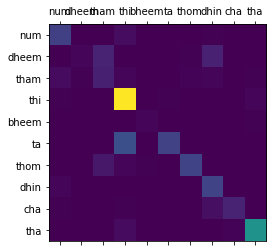

In [ ]:
#### Put the model in production
model.eval()

#### Compute metrics on the test set
trainer.test(test_dataloaders=test_loader)

#### Compute confusion matrix on the test set
confusion_matrix = model.test_cm.compute().cpu().numpy()
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.matshow(confusion_matrix)
ax.set_xticks(range(len(train_dataset.labels)))
ax.set_yticks(range(len(train_dataset.labels)))
ax.set_xticklabels(train_dataset.labels)
ax.set_yticklabels(train_dataset.labels)
plt.show()